In [1]:
import numpy as np
import torch
from sklearn.preprocessing import normalize
import cvxpy as cvx
import matplotlib.pyplot as plt
import torch.nn.functional as F 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import ipyparallel as ipp
rc = ipp.Client(profile="bluefog")
rc.ids

[0, 1, 2, 3]

# Federated Averaging Simulation

In [3]:
# Generate data and write auxilary functions.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
"""
Global Parameters:
    N (int) := Number of data points.
    dim (int) := Dimension of a data point.
    reg (float) := Regularization parameter.
    w (np.array) := Parameters of size (dim, 1).
    X (np.array) := Data of size (N, dim).
    y (np.array) := Labels of data of size (dim, 1).
    ss (float) := Step-size.
    ep (int) := Number of epochs in between a round of communication.
    batch (int) := Batch size.
    exp (int) := Number of experiments.
    comms (int) := Number of communications.
    num_workers (int) := Number of workers.
"""
N = 8000
dim = 10
reg = 1e-4
np.random.seed(0)

w = np.random.multivariate_normal([0.0]*dim, np.eye(dim), 1).T
X = np.random.multivariate_normal([0.0]*dim, np.eye(dim), size = N)
X = normalize(X, axis = 1, norm = 'l2')
y = 2 * (np.random.uniform(size = (N, 1)) < sigmoid(X @ w)) - 1
ss = 0.1
ep = 1
batch = 50
exp = 5
comms = 100
num_workers = len(rc.ids)

In [4]:
# Solve using CVX to find the optimal solution.
w_star = cvx.Variable((dim, 1))
loss = 1/N * cvx.sum(cvx.logistic(-cvx.multiply(y, X @ w_star))) + reg/2 * cvx.sum_squares(w_star)
problem = cvx.Problem(cvx.Minimize(loss))
problem.solve(verbose = False, abstol = 1e-15)
opt = problem.value
print(f'Optimal objective function value is: {opt}')

Optimal objective function value is: 0.558468913332832


In [5]:
# Convert numpy arrays to PyTorch tensor.
w_star_tensor = torch.from_numpy(w_star.value)
X_tensor = torch.Tensor(X).to(torch.float32)
y_tensor = torch.Tensor(y).to(torch.float32)

In [6]:
dview = rc[:]
dview.block=True
dview.push({'number_workers':len(rc.ids)})
dview.push({'w_star_tensor': w_star_tensor})
dview.push({'X_tensor': X_tensor})
dview.push({'y_tensor': y_tensor})
dview.push({'reg': reg})
dview.push({'step_size': ss})
dview.push({'epochs': ep})
dview.push({'batch': batch})
dview.push({'comms': comms})

[None, None, None, None]

In [7]:
import bluefog.torch as bf
bf.init()
import torch

In [8]:
%%px
import Documents.tutorials.classifier as classifier
%load_ext autoreload
%autoreload 2
solver = classifier.LogReg(w_star_tensor)

[stdout:0] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:1] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:2] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:3] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
MSE = torch.zeros((comms, 1))
for j in range(exp):
    for i in range(comms):
        aggregate_w = torch.zeros((dim , 1))
        %px _, _, _ = solver.SGD(X_tensor, y_tensor, step_size=step_size, epochs=epochs, batch_size=batch)
        for j in range(num_workers):
            aggregate_w += dview.pull('solver.w', block=True, targets=j)
        aggregate_w /= num_workers
        dview.push({'solver.w': aggregate_w})
#         if i % 10 == 0:
#             print(f'Server Parameter: {aggregate_w}')
#             %px print(f'Local Parameter: {solver.w}')
        MSE[i] += (torch.norm(aggregate_w-w_star_tensor, p=2))
MSE = 10 * torch.log(MSE/exp)

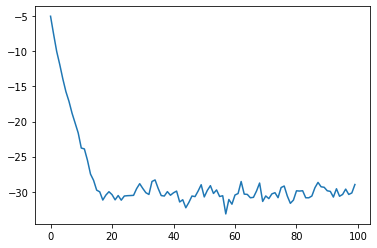

In [10]:
plt.plot(MSE)

In [ ]:
%%px
print(solver.obj(X_tensor, y_tensor, reg))

# SCAFFOLD Simulation

In [ ]:
# Generate data and write auxilary functions.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
"""
Global Parameters:
    N (int) := Number of data points.
    dim (int) := Dimension of a data point.
    reg (float) := Regularization parameter.
    w (np.array) := Parameters of size (dim, 1).
    X (np.array) := Data of size (N, dim).
    y (np.array) := Labels of data of size (dim, 1).
    ss (float) := Step-size.
    ep (int) := Number of epochs in between a round of communication.
    batch (int) := Batch size.
    exp (int) := Number of experiments.
    comms (int) := Number of communications.
    num_workers (int) := Number of workers.
"""
N = 8000
dim = 10
reg = 1e-4
np.random.seed(0)

w = np.random.multivariate_normal([0.0]*dim, np.eye(dim), 1).T
X = np.random.multivariate_normal([0.0]*dim, np.eye(dim), size = N)
X = normalize(X, axis = 1, norm = 'l2')
y = 2 * (np.random.uniform(size = (N, 1)) < sigmoid(X @ w)) - 1
ss = 0.1
ep = 1
batch = 50
exp = 1
comms = 100
num_workers = len(rc.ids)

In [ ]:
# Solve using CVX to find the optimal solution.
w_star = cvx.Variable((dim, 1))
loss = 1/N * cvx.sum(cvx.logistic(-cvx.multiply(y, X @ w_star))) + reg/2 * cvx.sum_squares(w_star)
problem = cvx.Problem(cvx.Minimize(loss))
problem.solve(verbose = False, abstol = 1e-15)
opt = problem.value
print(f'Optimal objective function value is: {opt}')

In [ ]:
# Convert numpy arrays to PyTorch tensor.
w_star_tensor = torch.from_numpy(w_star.value)
X_tensor = torch.Tensor(X).to(torch.float32)
y_tensor = torch.Tensor(y).to(torch.float32)

In [ ]:
dview = rc[:]
dview.block=True
dview.push({'number_workers':len(rc.ids)})
dview.push({'w_star_tensor': w_star_tensor})
dview.push({'X_tensor': X_tensor})
dview.push({'y_tensor': y_tensor})
dview.push({'reg': reg})
dview.push({'step_size': ss})
dview.push({'epochs': ep})
dview.push({'batch': batch})
dview.push({'comms': comms})

In [ ]:
import bluefog.torch as bf
bf.init()
import torch

In [ ]:
%%px
import Documents.tutorials.classifier as classifier
solver = classifier.LogReg(w_star_tensor)

In [ ]:
MSE = torch.zeros((comms, 1))
for j in range(exp):
    server_w = torch.rand((dim, 1))
    c_server = 0.0
    for i in range(comms):
        # Push server variables to clients.
        dview.push({'server_w': server_w})
        dview.push({'c_server': c_server})
        # Create storage variables for aggregates.
        aggregate_w_delta = torch.zeros((dim, 1))
        aggregate_c_delta = 0.0
        # Run local updates.
        %px delta_w, delta_c = solver.SCAFFOLD_Local(X_tensor, y_tensor, server_w, c_server, step_size=0.1, reg=1e-4, iterations=100, batch_size=50)
        for j in range(num_workers):
            aggregate_w_delta += dview.pull('delta_w', block=True, targets=j)
            aggregate_c_delta += dview.pull('delta_c', block=True, targets=j)
        aggregate_w_delta /= num_workers
        aggregate_c_delta /= num_workers
        server_w = server_w + .5 * aggregate_w_delta
        c_server = c_server + aggregate_c_delta
        MSE[i] += (torch.norm(server_w-w_star_tensor, p=2))
MSE = 10 * torch.log(MSE/exp)

In [ ]:
plt.plot(MSE)

In [ ]:
# %%px
# bf.suspend()

In [ ]:
# %%px
# import os

# print(os.getcwd())